In [103]:
import networkx as nx
import matplotlib.pyplot as plt

darvis_fn = "/home/sofiya/darvis-home/darvis/darvis/essential_graph.txt"
orbslam_fn = "/home/sofiya/darvis-home/darvis-orbslam3/essential_graph.txt"

def add_node(new_node, current):
    current["nodelist"].add(new_node)
    current["G"].add_node(new_node)

    if new_node in current["loop nodes"]:
        current["inserted loop nodes"].append(new_node)
    elif new_node >= current["region nodes"][0] and new_node <= current["region nodes"][1]:
        current["inserted region nodes"].append(new_node)
    else:
        current["inserted regular nodes"].append(new_node)

            
def add_edges_of_type(line, edge_type, current):
    edges_vec = line.split(":")[1].rstrip().split(",")[:-1]
    for edge in edges_vec:
        left_node, right_node = map(lambda n: int(n.strip()), edge.split("->"))
        
        if not left_node in current["nodelist"]:
            add_node(left_node, current)
        if not right_node in current["nodelist"]:
            add_node(right_node, current)

        current["G"].add_edge(right_node, left_node)
        current["edgelist"].append((right_node, left_node))

    
def process_file(filename, loop_nodes, region_nodes, system_name):
    current = {
        "G": nx.Graph(),
        "nodelist": set(),
        "edgelist": [],
        "pos_before": {},
        "pos_after": {},
        "inserted loop nodes": [],
        "inserted regular nodes": [],
        "inserted region nodes": [],
        "loop nodes": loop_nodes,
        "region nodes": region_nodes,
    }

    for line in open(filename, "r"):
        if "Loop edges #1" in line:
            add_edges_of_type(line, "loop 1", current)
        elif "Covisible edges" in line:
            add_edges_of_type(line, "covisibile", current)
        elif "Span edges" in line:    
            add_edges_of_type(line, "span", current)
        elif "Loop edges #2" in line:
            add_edges_of_type(line, "loop 2", current)
        elif "keyframe vertex" in line:
            kf_id = int(line.split("vertex")[1].split("with")[0].strip())
            if system_name == "darvis":
                x, y, z = map(lambda n: float(n.strip()), line.split("t[")[1].split("]")[0].split(","))
            elif system_name == "orbslam":
                x, y, z = map(lambda n: float(n.strip()), line.split("estimate")[1].split())
            current["pos_before"][kf_id] = [x, z]
        elif "Optimize essential graph, for kf" in line:
            kf_id = int(line.split("kf")[1].split(":")[0].strip())
            if system_name == "darvis":
                x, y, z = map(lambda n: float(n.strip()), line.split(":")[1].split("]")[0].split("[")[1].split(","))
            elif system_name == "orbslam":
                x, y, z = map(lambda n: float(n.strip()), line.split(":")[1].split())

            current["pos_after"][kf_id] = [x, z]



    return current


def cull(results):
    def bounds(node):
#         lower_bound = node >= results["loop nodes"][0] - 20 and node <= results["loop nodes"][0] + 20
#         upper_bound = node >= results["loop nodes"][1] - 30 and node <= results["loop nodes"][1] + 30

        lower_bound = node >= results["region nodes"][0] - 20
        upper_bound = node <= results["region nodes"][0] + 20 

        return lower_bound and upper_bound

    new_nodelist = []
    new_edgelist = []
    
    for node in results["inserted regular nodes"]:
        if bounds(node):
            new_nodelist.append(node)
    
    for edge_l, edge_r in results["edgelist"]:
        if bounds(edge_l) or bounds(edge_r):
            new_edgelist.append((edge_l, edge_r))

    return new_nodelist, new_edgelist
            
        
def plot(results, after_optimization):
    G = results["G"]
    loop_nodes = results["inserted loop nodes"]
    region_nodes = results["inserted region nodes"]
    
    # To show just relevant loop closure region:
    regular_nodes, edgelist = cull(results)

    # To show full graph:
    # regular_nodes = results["inserted regular nodes"]
    # edgelist = results["edgelist"]

    # To graph real positions of nodes:
    if after_optimization:
        pos = results["pos_after"]
    else:
        pos = results["pos_before"]
    
    # To graph positions so graph looks nice from graphing library:
    # pos = nx.nx_agraph.graphviz_layout(results["G"])

    fig, ax = plt.subplots(figsize=(10,10))

    options = {"edgecolors": "tab:gray", "node_size": 600, "alpha": 0.9}
    nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes, node_color="tab:blue", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=region_nodes, node_color="orange", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=loop_nodes, node_color="cyan", **options)

    nx.draw_networkx_edges(G, pos, edgelist=edgelist, width=1.0, alpha=0.5)

    nx.draw_networkx_labels(G, pos)
    


results_darvis = process_file(darvis_fn, [90, 877], [861, 878], "darvis")
results_orbslam = process_file(orbslam_fn, [80, 769], [759, 768], "orbslam")


Darvis before optimization
Darvis after optimization


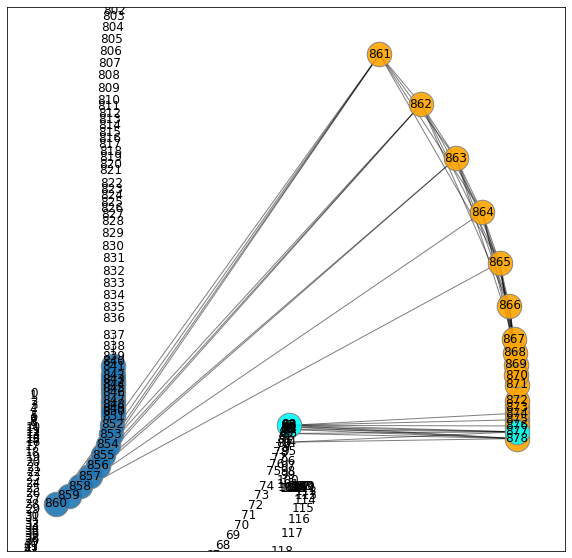

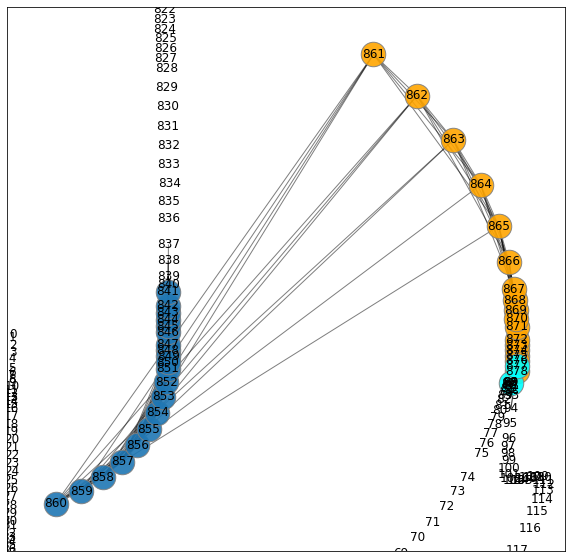

In [107]:
print("Darvis before optimization")
plot(results_darvis, 0)

print("Darvis after optimization")
plot(results_darvis, 1)

Orbslam before optimization


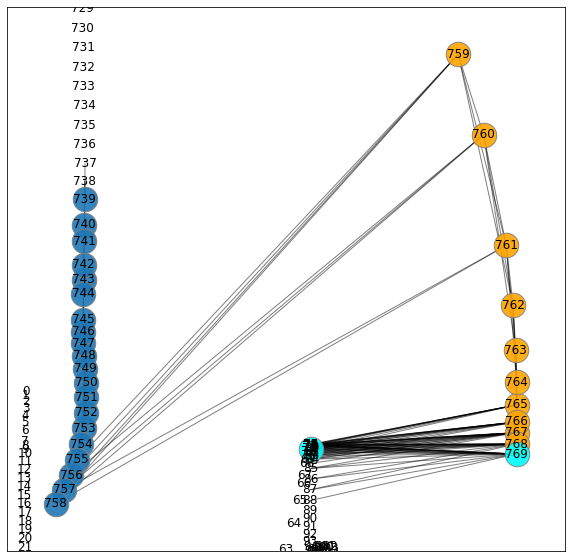

In [105]:
print("Orbslam before optimization")
plot(results_orbslam, 0)

Orbslam after optimization


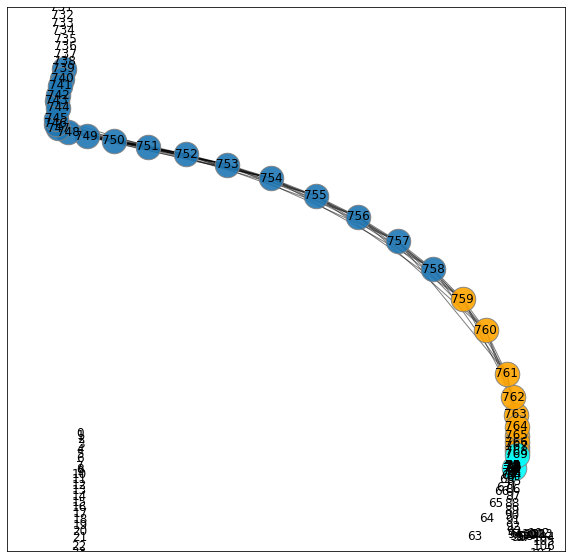

In [106]:
print("Orbslam after optimization")
plot(results_orbslam, 1)